# Subword Tokenization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from collections import Counter

import pandas as pd
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("scripts")
from scripts.steam_review_dataset import SteamReviewDataset

In [3]:
# Lade die CSV-Datei mit den Rezensionen
df = pd.read_csv("../data/reviews_100k_cleaned_new.csv.bz2")
model_type = "unigram"

Die Auswahl des `model_type` hängt von verschiedenen Faktoren ab:

- **Unigram:**  
  Dies ist eine gute Wahl, wenn Subwörter erzeugt werden sollen, die auf der Wahrscheinlichkeit basieren, mit der sie in den Trainingsdaten auftreten. Der **Unigram-Ansatz** ist besonders gut geeignet, wenn längere Texten und eine breite Wortvielfalt vorliegt.  
  - **Vorteil:** Flexibel und gut bei der Modellierung von seltenen Wörtern.
  - **Nachteil:** Kann in einigen Fällen schwieriger zu interpretieren sein.

- **BPE (Byte Pair Encoding):**  
  BPE eignet sich gut für die Tokenisierung von Texten mit einer klaren Struktur, in denen häufig vorkommende Wortbestandteile aufgeteilt werden. Wenn eine hohe Anzahl an kurzen, häufigen Wörtern vorliegt (z. B. in der Umgangssprache), ist BPE effizient.
  - **Vorteil:** Gut für sehr häufig vorkommende Wortteile.
  - **Nachteil:** Kann dazu führen, dass sehr seltene Wörter zusammengebunden werden.

In [4]:
# Extrahiere alle Rezensionen in eine einzige Textdatei
with open("../tmp/reviews.txt", "w") as f:
    for review in df["review"]:
        f.write(review + "\n")

vocab_size = 4000

spm.SentencePieceTrainer.Train(
    input="../tmp/reviews.txt",  # Textdatei mit allen Rezensionen
    model_prefix=f"../data/reviews_{model_type}",  # Präfix für die erzeugten Dateien
    vocab_size=vocab_size,  # Größe des Vokabulars
    model_type=model_type,  # Tokenisierungsmodell
    max_sentence_length=8000,  # Maximale Satzlänge (reviews sind 4 bis 7604 Zeichen lang)
    pad_id=0,  # Padding-Token explizit setzen
    unk_id=1,  # Unbekanntes Token setzen
    bos_id=2,  # Anfang des Satzes
    eos_id=3,  # Ende des Satzes
)

# Nach dem Training werden zwei Dateien erstellt:
# - reviews_{model_type}.model (Tokenisierungsmodell)
# - reviews_{model_type}.vocab (Vokabular)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../tmp/reviews.txt
  input_format: 
  model_prefix: ../data/reviews_unigram
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 8000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differentia

In [5]:
sp = spm.SentencePieceProcessor(model_file=f"../data/reviews_{model_type}.model")

print(f"Size of the vocabulary: {sp.get_piece_size()}")
print(f"Padding token ID: {sp.pad_id()}")

Size of the vocabulary: 4000
Padding token ID: 0


In [6]:
# Welche Zeichen sind im Vokabular nicht enthalten?

with open("../tmp/reviews.txt", "r") as f:
    all_text = f.read()

covered_chars = set(
    sp.id_to_piece(i) for i in range(sp.get_piece_size())
)  # Alle Tokens
all_chars = set(all_text)  # Alle Zeichen in den Texten

# Nicht abgedeckte Zeichen
uncovered_chars = all_chars - covered_chars

print(f"Total characters: {len(all_chars)}")
print(f"Uncovered characters: {len(uncovered_chars)}")
print("Uncovered characters:", uncovered_chars)

Total characters: 28
Uncovered characters: 2
Uncovered characters: {' ', '\n'}


In [10]:
# Beispiel-Rezension
review = "the game is great and a lot of fun"

# Tokenisierung der Rezension
tokens = sp.encode(review, out_type=str)

# Ausgabe der Original-Rezension und der tokenisierten Form
print("Original Review:")
print(review)

print("\nTokenized Form:")
print(tokens)

print("\nToken ID pairs:")
for token in tokens:
    print(f"{token} -> {sp.piece_to_id(token)}")

Original Review:
the game is great and a lot of fun

Tokenized Form:
['▁the', '▁game', '▁i', 's', '▁great', '▁and', '▁a', '▁lot', '▁of', '▁fun']

Token ID pairs:
▁the -> 4
▁game -> 8
▁i -> 10
s -> 32
▁great -> 65
▁and -> 6
▁a -> 9
▁lot -> 94
▁of -> 12
▁fun -> 37


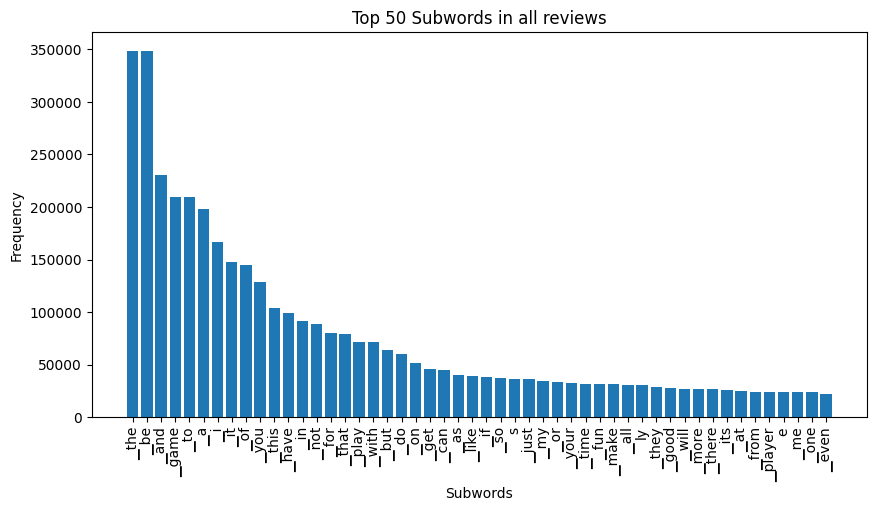

In [8]:
# Zähle die Subwörter in alllen Rezensionen
all_tokens = []

for review in df["review"]:
    tokens = sp.encode(review, out_type=str)
    all_tokens.extend(tokens)  # Alle Tokens in der Liste speichern

# Zähle die Häufigkeit der Subwörter
word_counts = Counter(all_tokens)

top_n = 50
top_words = word_counts.most_common(top_n)

# Visualisierung der Top-N Subwörter
top_words_dict = dict(top_words)

plt.figure(figsize=(10, 5))
plt.bar(top_words_dict.keys(), top_words_dict.values())
plt.xticks(rotation=90)
plt.title(f"Top {top_n} Subwords in all reviews")
plt.xlabel("Subwords")
plt.ylabel("Frequency")
plt.show()

Das folgende Diagram kann verwendet werden, um eine gute Wahl für `max_len` im `SteamReviewDataset` zu treffen.
Beispielsweise deckt ein `max_len` von 200 bei einer `vocab_size` von 4.000 bereits 91% der Daten ab. Das heißt nur 9% der Daten werden abgeschnitten.

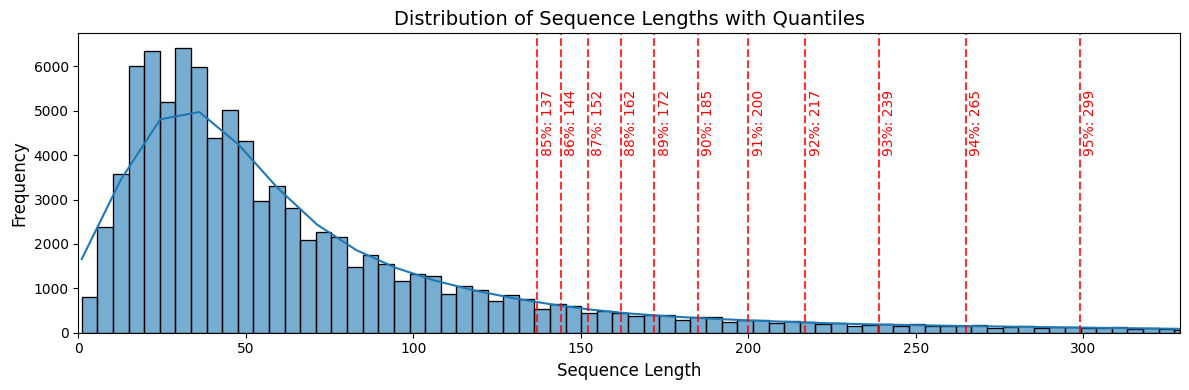

In [9]:
dataset = SteamReviewDataset(df, sp, padding=False)

# Längen der Token-Sequenzen
lengths = [len(tokens) for tokens, _ in dataset]

# Berechnung der Quantile
quantiles = pd.Series(lengths).quantile([x / 100 for x in range(85, 96, 1)])

# Plot
plt.figure(figsize=(12, 4))

# Limit der x-Achse auf den letzten Quantilwert (mit Puffer)
plt.xlim(0, quantiles.iloc[-1] * 1.1)

# Histogramm der Sequenzlängen
sns.histplot(lengths, bins=500, kde=True, alpha=0.6, label="Sequence Lengths")

# Vertikale Linien und Labels für die Quantile
for q, value in quantiles.items():
    plt.axvline(
        x=value,
        linestyle="--",
        color="red",
        alpha=0.8,
    )
    plt.text(
        x=value + 1,
        y=plt.gca().get_ylim()[1] * 0.6,
        s=f"{int(q * 100)}%: {int(value)}",
        rotation=90,
        color="red",
    )

# Labels und Titel
plt.title("Distribution of Sequence Lengths with Quantiles", fontsize=14)
plt.xlabel("Sequence Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()